In [472]:
import sys
import json

params = {}
         
default = {'training_folder': '../../scenarios/jakarta', 'params':params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/jakarta', 'params': {}}


In [473]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
#from quetzal.engine.road_model import RoadModel
#from quetzal.engine.pathfinder_utils import get_path, parallel_dijkstra, build_index, sparse_matrix
#from quetzal.engine.msa_utils import get_zone_index, assign_volume
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point
#from typing import Tuple
#from geopy.distance import geodesic  # works for geopy version >=2
#from sklearn.cluster import KMeans
#from syspy.spatial.spatial import nearest, agglomerative_clustering, voronoi_diagram_dataframes, add_geometry_coordinates
#from quetzal.engine.pathfinder_utils import simple_routing,get_path
num_cores = 1

In [474]:
def get_epsg(lat: float, lon: float) -> int:
    '''
    return EPSG in meter for a given (lat,lon)
    lat is north south 
    lon is est west
    '''
    return int(32700 - round((45 + lat) / 90, 0) * 100 + round((183 + lon) / 6, 0))

def get_flight_distance(x):
    # inputs : [(lat,lon), (lat,lon)]. or [(y,x),(y,x)]
    # however. geodesic use lon,lat. so its inverted here
    return geodesic(x[0], x[1]).m




In [475]:
def create_mesh(zones: gpd.GeoDataFrame ,step: float = 0.01) -> gpd.GeoDataFrame:
    '''
    create a mesh in the zones total bbox at every step (in the units of the zones crs)
    step: degree if crs=4326, else meters.
    '''
    x_max, y_max = zones.bounds.max()[['maxx','maxy']].values
    x_min, y_min = zones.bounds.min()[['minx','miny']].values

    points = []
    x = x_min
    while x<x_max:
        y = y_min
        while y<y_max:
            points.append(Point(x,y))
            y += step
        x += step
    points = gpd.GeoDataFrame(geometry=points,crs=zones.crs)
    points.index.name='index'
    return points

# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
from numba import jit, njit
import numba
@jit(nopython=True)
def fast_point_in_polygon(x,y,poly):
    n = len(poly)
    inside = False
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x,p1y = poly[0]
    for i in numba.prange(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y
        
    return inside


@njit(parallel=True)
def fast_points_in_polygon(points, polygon):
    D = np.empty(len(points), dtype=numba.boolean) 
    for i in numba.prange(0, len(points)):
        D[i] = fast_point_in_polygon(points[i,0], points[i,1], polygon)
    return np.where(D)[0]

def points_in_polygon(points:np.ndarray, polygon:gpd.GeoDataFrame) -> np.ndarray:
    '''
    return a list of point in the polygon. values are the index in the points array.
    
    points:np.array[np.array[float,float]]
        list of all the points coords (x,y)
    polygon: gpd.GeoDataFrame
        geodataframe of multiples polygons.
    '''
    polygon = np.array([*polygon.exterior.coords])
    return fast_points_in_polygon(points,polygon)


def population_to_mesh(population: gpd.GeoDataFrame, step: float=0.01,population_col='population') ->  gpd.GeoDataFrame:
    '''
    create a mesh in the zones total bbox at every step (in the units of the zones crs)
    and assign the population to each node equaly (if 2 node in a zone. they have each 50% of the population)
    population:
        geodataframe with total population by zones ans zones geomerty
    step: 
        degree if crs=4326, else meters.
    '''
    import warnings
    warnings.filterwarnings('ignore')
    population=population.copy()
    if population.index.name != 'index':
        population.index.name = 'index'
    points = create_mesh(population, step=step)
    points_coords = np.array([point.coords[0] for point in points['geometry'].values])
    
    population['nodes'] = population['geometry'].apply(lambda x: points_in_polygon(points_coords,x))
    
    nodes = population.reset_index()[['index','nodes',population_col]].copy()
    nodes = nodes.explode('nodes').dropna()
    print(len(nodes[nodes['nodes'].duplicated()]),'nodes in multiple zones')
    
    
    zone_index_dict = nodes.set_index('nodes')['index'].to_dict()
    points['zone'] = points.index.map(zone_index_dict)

    pop_dict = nodes.set_index('nodes')[population_col].to_dict()
    points[population_col] = points.index.map(pop_dict)
    points = points.dropna()
    
    # get number of points per zones. divide population equaly between each points
    len_dict = points.groupby('zone')[population_col].agg(len).to_dict()
    points['num_points'] = points['zone'].apply(lambda x:len_dict.get(x))
    points[population_col] = points[population_col] / points['num_points']
    points = points.drop(columns = ['num_points'])
    
    print(len(population) - len(points['zone'].unique()),'unfounded zones. centroids will be added to the mesh')
    
    # find zones not in any points of the mesh.
    # add those zones centroid as a single mesh point.
    zones_list = points['zone'].unique()
    unfounded_zones = population.loc[~population.index.isin(zones_list)][['geometry',population_col]]
    unfounded_zones['geometry'] = unfounded_zones.centroid

    unfounded_zones = unfounded_zones.reset_index().rename(columns={'index':'zone'})
    points = pd.concat([points,unfounded_zones]).reset_index(drop=True)
    points.index.name='index'
    
    return points

In [476]:
base_folder = argv['training_folder']
pt_folder = base_folder + '/inputs/pt/'
input_folder = base_folder +'/inputs/'
od_folder = base_folder + '/inputs/od/'
output_folder = base_folder +'/outputs/'
print(pt_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


../../scenarios/jakarta/inputs/pt/


# inputs

In [477]:
#cst_incline = argv['params' ]['constant']['cst_incline']
#cst_road = argv['params']['road_weight']
#cst_shared = argv['params']['shared_cycleway_weight']

In [478]:
links = gpd.read_file(pt_folder + 'links.geojson') 
nodes = gpd.read_file(pt_folder + 'nodes.geojson')
links = links.set_index('index')
nodes = nodes.set_index('index')

In [479]:
population = gpd.read_file(input_folder + 'population.geojson')
if 'index' in population.columns:
    population = population.set_index('index')
else:
    population.index.name='index'

In [480]:
od_file = od_folder + 'od.geojson'
od_file_provided = os.path.isfile(od_file)
if od_file_provided:
    od_test = gpd.read_file(od_folder + 'od.geojson')
    if 'name' not in od_test.columns:
        od_test['name'] = od_test['index']
    od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))

# population preapation

In [481]:
#get_epsg( -6.58316,106.79165)

In [482]:
centroid = [*population.centroid[0].coords][0]

In [483]:
crs = get_epsg(centroid[1],centroid[0])

In [484]:
population['area (km2)'] = population.to_crs(crs).area*1e-6
population['area (km2)'].sum()

6803.724157998284

In [485]:
population['population'] = population['density']*population['area (km2)']
population['population'].sum()

31232829.78657818

# population mesh

In [486]:
mesh = population_to_mesh(population, step=0.01, population_col = 'population')

0 nodes in multiple zones
66 unfounded zones. centroids will be added to the mesh


In [487]:
mesh.to_file(output_folder + 'population_mesh.geojson',driver='GeoJSON')

# catchment

In [488]:
len(links['route_id'].unique())

217

In [489]:
len(links['route_type'].unique())

1

In [591]:
def nearest(one, many, radius=100, geometry=False):
    try:
        # Assert df_many.index.is_unique
        assert one.index.is_unique
        assert many.index.is_unique
    except AssertionError:
        msg = 'Index of one or many should not contain duplicates'
        print(msg)
        warnings.warn(msg)
    many = add_geometry_coordinates(many.copy(), columns=['x_geometry', 'y_geometry'])
    one = add_geometry_coordinates(one.copy())
    
    x = many[['x_geometry', 'y_geometry']].values
    # Fit Nearest neighbors model
    #nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(x)
    nbrs = NearestNeighbors(radius=radius,algorithm='ball_tree').fit(x)


    # x = df_many[['x_geometry','y_geometry']].values
    y = one[['x_geometry', 'y_geometry']].values

    #distances, indices = nbrs.kneighbors(y,return_distance=True)
    distances, indices = nbrs.radius_neighbors(y, radius = radius, return_distance=True)

    indices = pd.DataFrame(indices)
    indices = pd.DataFrame(indices.stack(), columns=['index_nn']).reset_index().rename(
        columns={'level_0': 'ix_one', 'level_1': 'rank'}
    )
    indices['distances'] = distances
    return indices

In [592]:
from syspy.spatial.spatial import add_geometry_coordinates
from sklearn.neighbors import NearestNeighbors



In [ ]:
# find TC nodes to mesh distance

In [755]:
node_dist = nearest(nodes.to_crs(crs),mesh.to_crs(crs),3000)
node_dist = node_dist.rename(columns={'ix_one': 'node_index','index_nn':'mesh_index'}).drop(columns='rank')

In [756]:
nodes_index_dict = nodes.reset_index()['index'].to_dict()
node_dist['node_index'] = node_dist['node_index'].apply(lambda x: nodes_index_dict.get(x))

In [757]:
node_dist = node_dist.explode(['mesh_index','distances'])
population_dict = mesh['population'].to_dict()
node_dist['population'] = node_dist['mesh_index'].apply(lambda x: population_dict.get(x))


In [758]:
len(links['route_id'].unique())

217

In [759]:
%%time
res={}
for route_id in links['route_id'].unique():
    link = links[links['route_id'] == route_id]
    nodes_set = (set(link['a'].values).union(set(link['a'].values)))
    link_nodes = node_dist[node_dist['node_index'].isin(nodes_set)]
    volume = link_nodes.drop_duplicates('mesh_index')['population'].sum()
    res[route_id] = volume
print(sum([item for key,item in res.items()]))

357239472.2862398
CPU times: user 1.49 s, sys: 4.04 ms, total: 1.49 s
Wall time: 1.49 s


In [760]:
%%time
res={}
for route_id in links['route_type'].unique():
    link = links[links['route_type'] == route_id]
    nodes_set = (set(link['a'].values).union(set(link['a'].values)))
    link_nodes = node_dist[node_dist['node_index'].isin(nodes_set)]
    volume = link_nodes.drop_duplicates('mesh_index')['population'].sum()
    res[route_id] = volume
print(sum([item for key,item in res.items()]))

17020132.917962827
CPU times: user 32.8 ms, sys: 11 µs, total: 32.8 ms
Wall time: 31.9 ms


In [766]:
%%time
res=[]
dists = [0,1,10,20,50,100,500,1000,2]
for dist in dists:
    nodes_set = (set(links['a'].values).union(set(links['a'].values)))
    link_nodes = node_dist[node_dist['node_index'].isin(nodes_set)]
    link_nodes = link_nodes[link_nodes['distances']<dist]
    volume = link_nodes.drop_duplicates('mesh_index')['population'].sum()
    res.append(volume)
    print(volume)

36609.18500763753
2479863.1200390784
13384986.8075926
15615014.072050348
17020132.917962827
CPU times: user 132 ms, sys: 3.99 ms, total: 136 ms
Wall time: 135 ms


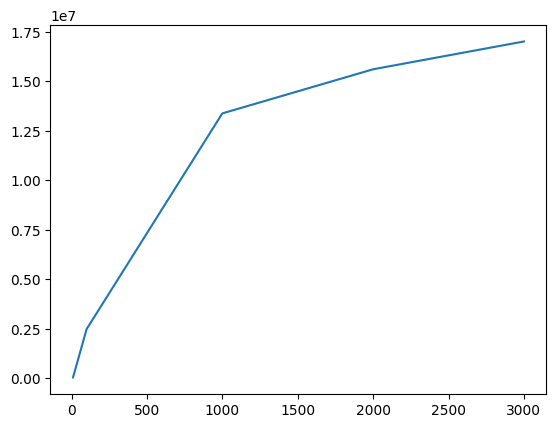

In [767]:
plt.plot(dists,res)

514930.4189033144

# test

In [706]:
node_dist

,node_index,mesh_index,distances
0,node_0,"[3049, 3050, 2918, 3048, 2920, 2984, 2985, 291...","[1265.465060434163, 1656.3926370385564, 1484.9..."
1,node_1,"[5551, 5564, 2995, 2996, 2929, 5602, 5607, 558...","[1977.6263879881608, 1960.3755783895344, 829.2..."
2,node_2,"[2402, 2403, 2464, 2466, 2594, 2467, 2530, 252...","[1611.907134086658, 1524.630724982175, 1817.96..."
3,node_3,"[3180, 3113, 3112, 3049, 3050, 3048, 2984, 311...","[1744.5176574733364, 778.5878831369325, 1747.3..."
4,node_4,"[2847, 2846, 2909, 2975, 2974, 2911, 2910, 297...","[1772.5251358715707, 1547.4060683290306, 1388...."
...,...,...,...
6982,node_6982,"[5588, 2933, 2869, 2998, 2802, 2932, 5561, 286...","[1249.648933240863, 588.6397682425078, 612.030..."
6983,node_6983,"[5588, 2933, 2869, 2998, 2802, 2932, 5561, 286...","[1297.7477565182787, 955.3407295483518, 818.96..."
6984,node_6984,"[3330, 3398, 3263, 3264, 3332, 3331, 3401, 333...","[1700.0196053775644, 1852.64700231443, 1524.44..."
6985,node_6985,"[3262, 3330, 3398, 3263, 3264, 3332, 3331, 333...","[1880.9875820290142, 1359.4710318811965, 1615...."


,node_index,mesh_index,distances
0,node_0,3049,1265.46506
0,node_0,3050,1656.392637
0,node_0,2918,1484.901861
0,node_0,3048,1704.593402
0,node_0,2920,1429.302763
...,...,...,...
6986,node_6986,3401,1502.371094
6986,node_6986,3333,1284.487034
6986,node_6986,3399,1266.282805
6986,node_6986,3400,840.834068
